In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

url = "/Users/ww/Downloads/california_housing.csv"
df = pd.read_csv(url)

# shape and size of the data
print("Dataset shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

# datatypes and duplicates
print("\nDataset information:")
print(df.info())

# duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")

# statistical information
print("\nStatistical summary:")
print(df.describe())

# distribution
print("\nTarget variable distribution:")
print(df['price_above_median'].value_counts())
print(df['price_above_median'].value_counts(normalize=True) * 100)

Dataset shape: (20634, 9)

First 5 rows of the dataset:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  2.1827      26.0  4.521429   0.921429       305.0  2.178571     40.05   
1  3.0755      32.0  4.623068   0.983353      3868.0  4.599287     32.77   
2  1.8235      40.0  4.701149   1.126437       928.0  3.555556     37.75   
3  1.4625      37.0  4.247845   1.105603      1673.0  3.605603     33.99   
4  1.9063      13.0  3.453125   0.984375       286.0  4.468750     33.97   

   Longitude  price_above_median  
0    -122.10                   0  
1    -117.06                   0  
2    -122.16                   0  
3    -118.28                   0  
4    -118.16                   0  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20634 entries, 0 to 20633
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MedInc              20634 non-null  float64


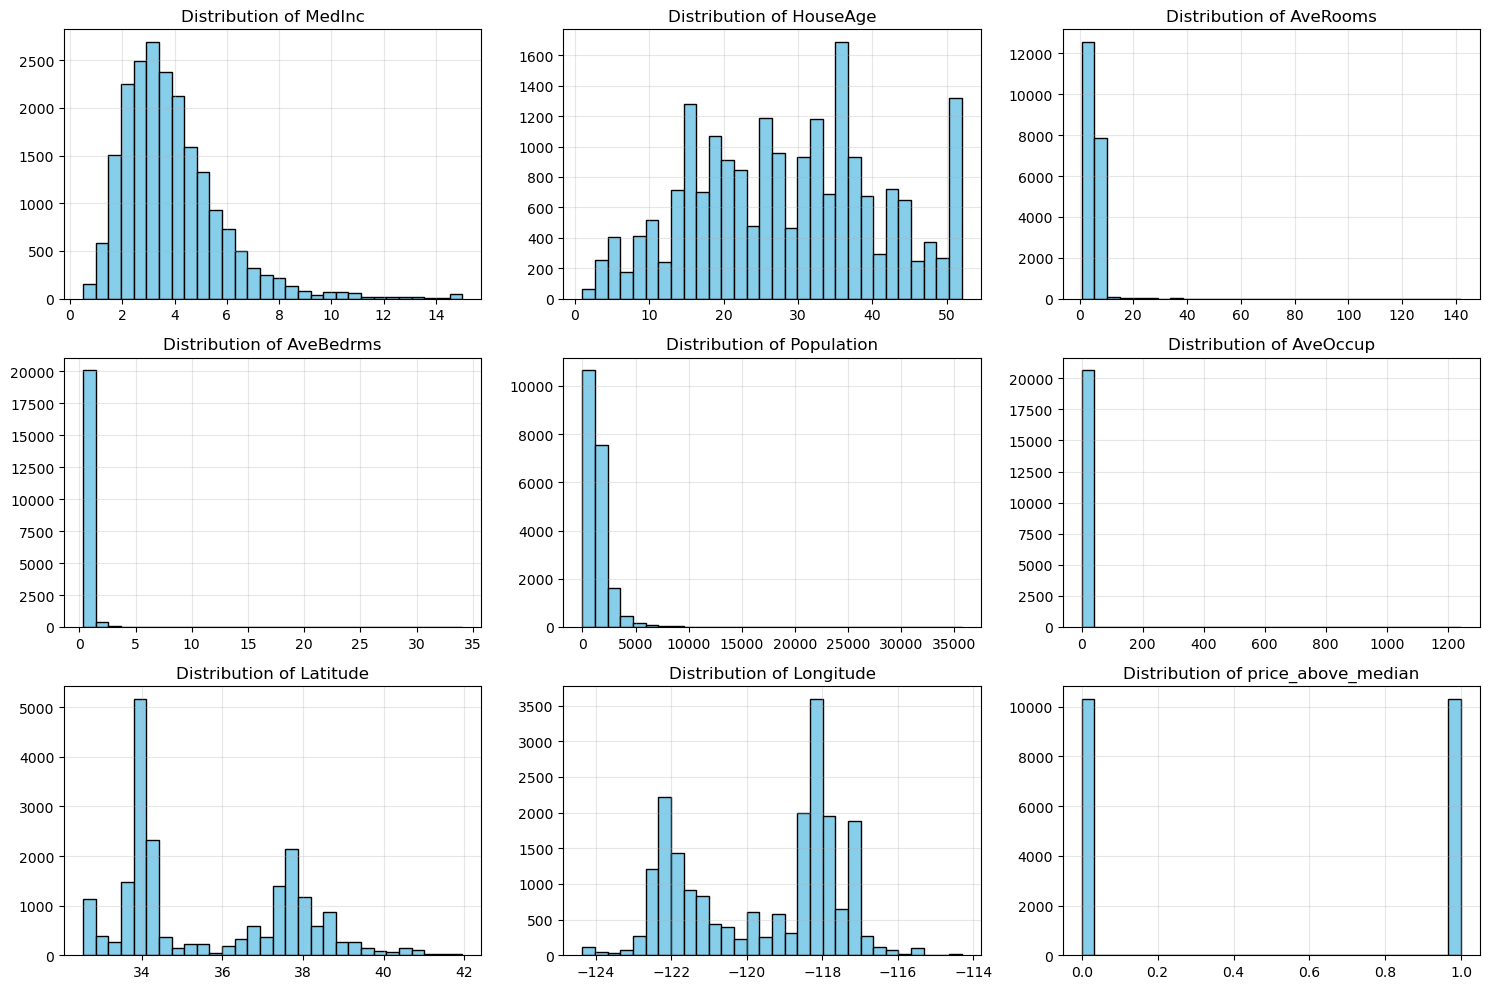

In [64]:
# visualize the dataset
plt.figure(figsize=(15, 10))

for i, column in enumerate(df.columns):
    plt.subplot(3, 3, i+1)
    plt.hist(df[column], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('univariate_analysis.png')

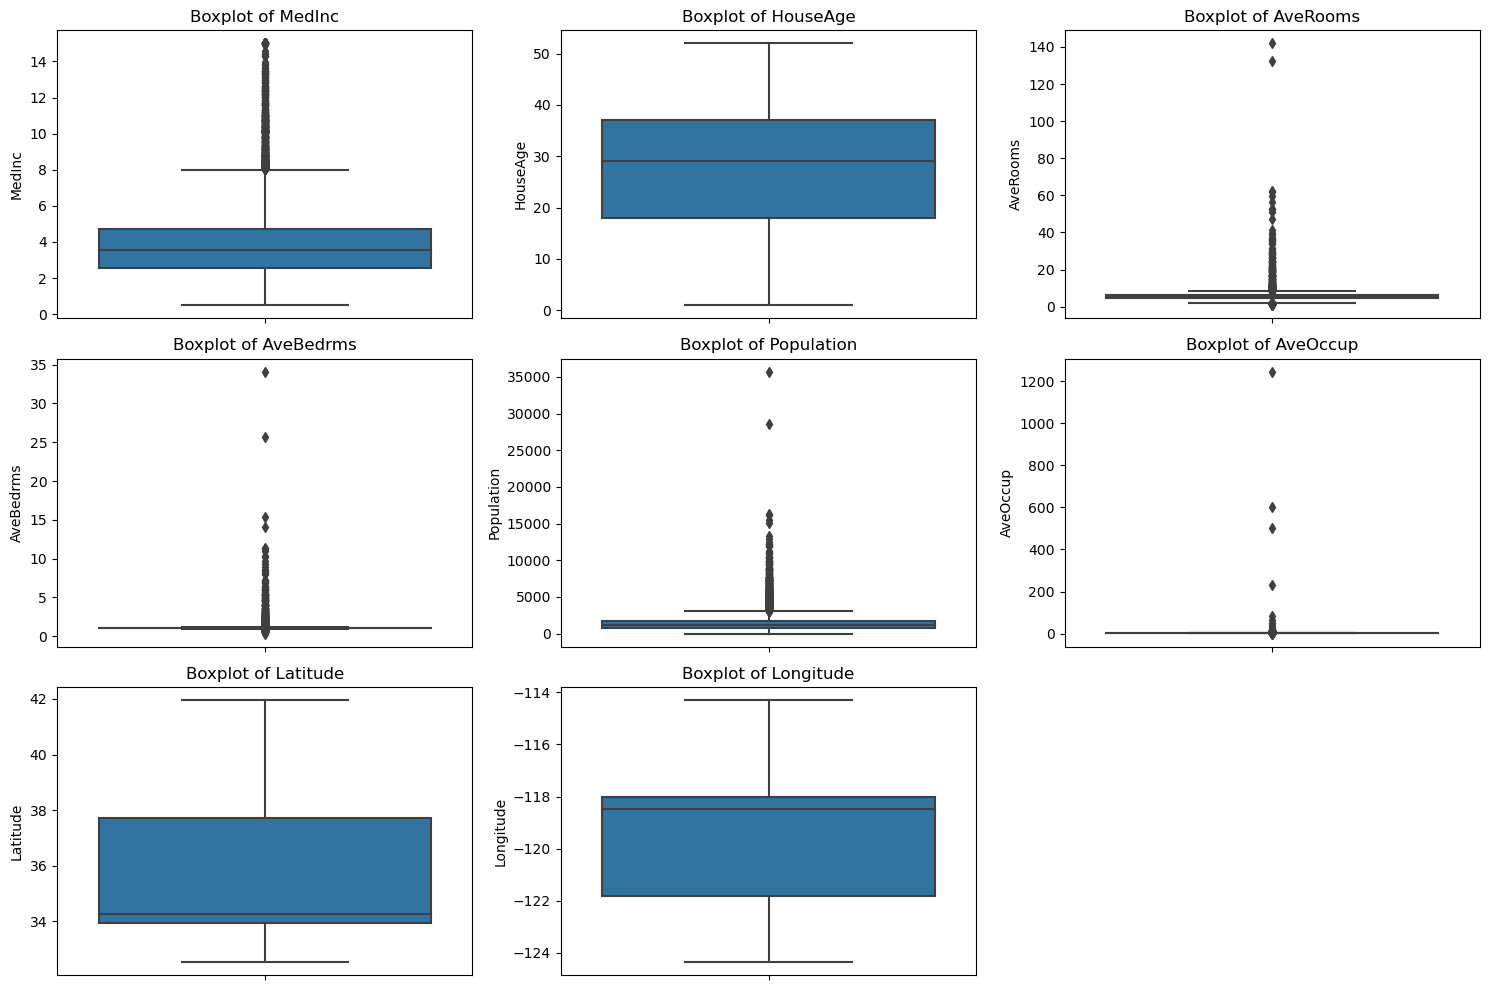

In [65]:
# boxplots
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1]):  # exclude target variable
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.savefig('boxplots.png')

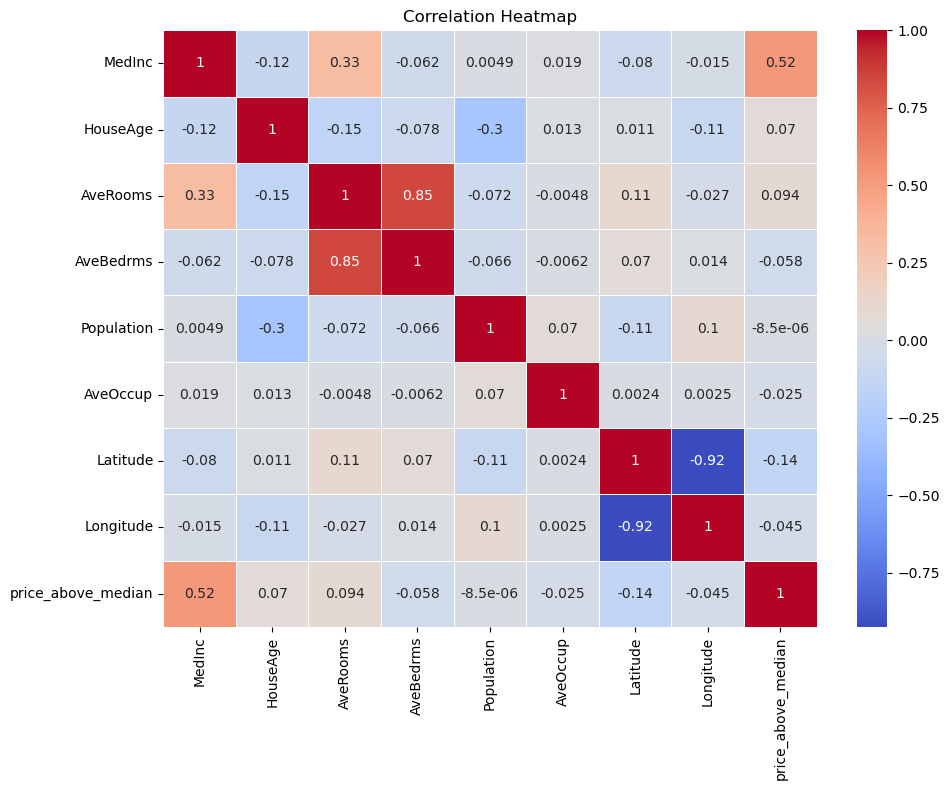

In [53]:
# heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

In [61]:
# Split the data
X = df.drop('price_above_median', axis=1)
y = df['price_above_median']

# Stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print(f"Training set class distribution: \n{y_train.value_counts(normalize=True) * 100}")
print(f"Testing set class distribution: \n{y_test.value_counts(normalize=True) * 100}")

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training set shape: (16507, 8)
Testing set shape: (4127, 8)
Training set class distribution: 
1    50.003029
0    49.996971
Name: price_above_median, dtype: float64
Testing set class distribution: 
0    50.012115
1    49.987885
Name: price_above_median, dtype: float64


In [59]:
models = {}
results = {}

# evaluate model and store results
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    
    # Store results
    results[model_name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'train_report': classification_report(y_train, y_pred_train, output_dict=True),
        'test_report': classification_report(y_test, y_pred_test, output_dict=True),
        'train_cm': confusion_matrix(y_train, y_pred_train),
        'test_cm': confusion_matrix(y_test, y_pred_test),
        'y_pred_test': y_pred_test
    }
    
    print(f"\n{model_name} Results:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing Precision: {test_precision:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print(f"Testing F1 Score: {test_f1:.4f}")
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test))
    
# Confusion Matrix
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(results[model_name]['train_cm'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Training Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(results[model_name]['test_cm'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Testing Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.close()
    
# KNN
knn_params = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')
evaluate_model('KNN', knn, X_train_scaled, X_test_scaled, y_train, y_test)

print(f"Best KNN parameters: {knn.best_params_}")

# Decision Tree
dt_params = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
evaluate_model('Decision Tree', dt, X_train_scaled, X_test_scaled, y_train, y_test)

print(f"Best Decision Tree parameters: {dt.best_params_}")

# Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
evaluate_model('Random Forest', rf, X_train_scaled, X_test_scaled, y_train, y_test)

print(f"Best Random Forest parameters: {rf.best_params_}")

# AdaBoost
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
ada = GridSearchCV(AdaBoostClassifier(random_state=42), ada_params, cv=5, scoring='accuracy')
evaluate_model('AdaBoost', ada, X_train_scaled, X_test_scaled, y_train, y_test)

print(f"Best AdaBoost parameters: {ada.best_params_}")

    


KNN Results:
Training Accuracy: 1.0000
Testing Accuracy: 0.8333
Testing Precision: 0.8263
Testing Recall: 0.8439
Testing F1 Score: 0.8350

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2064
           1       0.83      0.84      0.84      2063

    accuracy                           0.83      4127
   macro avg       0.83      0.83      0.83      4127
weighted avg       0.83      0.83      0.83      4127

Best KNN parameters: {'n_neighbors': 11, 'weights': 'distance'}

Decision Tree Results:
Training Accuracy: 0.9112
Testing Accuracy: 0.8476
Testing Precision: 0.8292
Testing Recall: 0.8754
Testing F1 Score: 0.8517

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      2064
           1       0.83      0.88      0.85      2063

    accuracy                           0.85      4127
   macro avg       0.85      0.85


Model Performance Comparison:

Model Metrics Summary:
           Model  Train Accuracy  Test Accuracy  Precision    Recall  F1 Score
0            KNN        1.000000       0.833293   0.826293  0.843917  0.835012
1  Decision Tree        0.911189       0.847589   0.829201  0.875424  0.851686
2  Random Forest        1.000000       0.886843   0.881818  0.893359  0.887551
3       AdaBoost        0.891198       0.870608   0.862151  0.882210  0.872065

Best performing model based on test accuracy: Random Forest


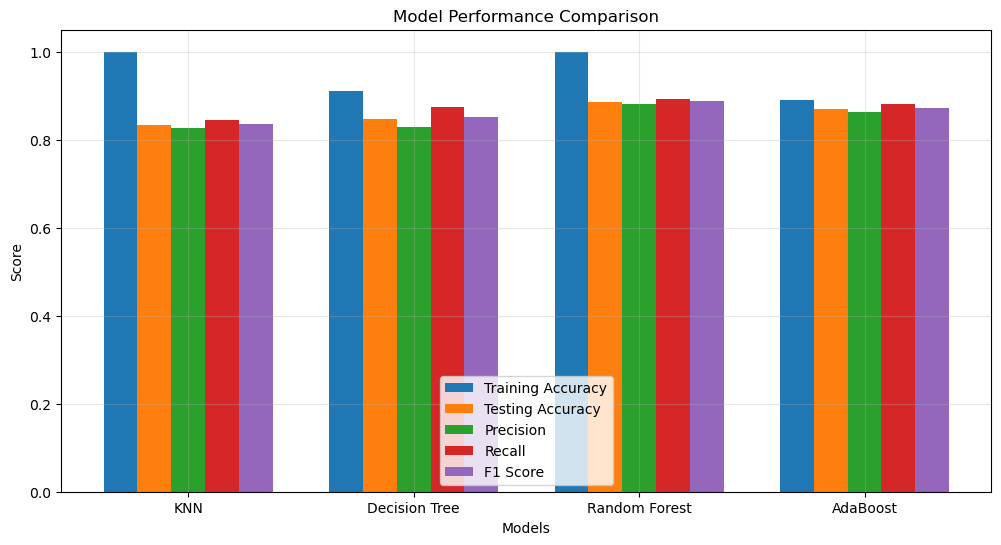

In [62]:
# Compare performances
print("\nModel Performance Comparison:")
model_names = list(results.keys())
train_accuracies = [results[model]['train_accuracy'] for model in model_names]
test_accuracies = [results[model]['test_accuracy'] for model in model_names]
test_precisions = [results[model]['test_precision'] for model in model_names]
test_recalls = [results[model]['test_recall'] for model in model_names]
test_f1s = [results[model]['test_f1'] for model in model_names]

plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.15

plt.bar(x - 2*width, train_accuracies, width, label='Training Accuracy')
plt.bar(x - width, test_accuracies, width, label='Testing Accuracy')
plt.bar(x, test_precisions, width, label='Precision')
plt.bar(x + width, test_recalls, width, label='Recall')
plt.bar(x + 2*width, test_f1s, width, label='F1 Score')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('model_comparison.png')

# dataframe
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Precision': test_precisions,
    'Recall': test_recalls,
    'F1 Score': test_f1s
})

print("\nModel Metrics Summary:")
print(metrics_df)

# best model
best_model_name = model_names[np.argmax(test_accuracies)]
print(f"\nBest performing model based on test accuracy: {best_model_name}")